Load Libraries & Raw Data 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

customers = pd.read_csv(r"E:\Case Study\customers.csv")
orders = pd.read_csv(r"E:\Case Study\orders.csv")
web_sessions = pd.read_csv(r"E:\Case Study\web_sessions.csv")

 Data Preparation Steps (Pre-Analysis Only)
 
1. Check Primary Key Uniqueness
2. Revenue should be non-null and greater than 0
3. Channels & Region should not be null
4. Customers' order date must be greater than their sign_up date 

In [6]:
# Basic Data Validation Summary

# Step 1 - Check the Uniqueness of the Primary Keys
print(customers['customer_id'].is_unique)  # Should be True
print(orders['order_id'].is_unique)        # Should be True
print(web_sessions['session_id'].is_unique)  # Should be True

# Step 2 - Revenue Should be Non-null & Greater Than 0
print("Null revenue:", orders['revenue'].isnull().sum())
print("Revenue <= 0:", (orders['revenue'] <= 0).sum())

# Step 3 - Channels & Region Should not Be Null
print("Missing channel:", customers['channel'].isnull().sum() + (customers['channel'] == '').sum())
print("Missing region:", customers['region'].isnull().sum() + (customers['region'] == '').sum())

# Step 4 - Customers' Order Date Must be Greater than Their Sign_up Date 
merged = pd.merge(orders, customers, on='customer_id', how='inner')
print("Orders before signup:", (merged['order_date'] < merged['signup_date']).sum())

True
True
True
Null revenue: 0
Revenue <= 0: 0
Missing channel: 0
Missing region: 0
Orders before signup: 0


Analysis Task 1 - Revenue by Segment

Calculate total revenue broken down by acquisition channel and region.

In [8]:
# Step 1 - Merge orders and customers
# Step 1.1) Customer_id is the common column, and the two tables join on this column
merged_df = pd.merge(orders, customers, on = 'customer_id', how = 'inner')

# Step 2 - Group Revenue by Channel & Region 
# Step 2.1) The merged table is grouped by region and channel (Group by)
# Step 2.2) Then, it calculates the total revenue (Sum)
# Step 2.3) Then, convert from Series to DataFrame (Reset_Index)
# Step 2.5) And finally, it sorts from the highest to the lowest revenue (Desc)
Revenue_Segmentation = merged_df.groupby(['channel', 'region'])['revenue'].sum().reset_index().sort_values(by='revenue', ascending = False)

# Step 3 - Printing the Results
total_revenue = Revenue_Segmentation['revenue'].sum()
Revenue_Segmentation['revenue_share_%'] = round((Revenue_Segmentation['revenue'] / total_revenue) * 100, 2)
print(Revenue_Segmentation)

        channel  region  revenue  revenue_share_%
5       organic      US  4753.54            11.51
14       social      US  4703.96            11.39
11     referral      US  4685.47            11.35
10     referral      UK  4123.85             9.99
13       social      UK  3822.54             9.26
3       organic  Canada  3424.45             8.30
12       social  Canada  2655.81             6.43
6   paid_search  Canada  2348.00             5.69
1         email      UK  2040.28             4.94
0         email  Canada  1654.02             4.01
4       organic      UK  1616.91             3.92
9      referral  Canada  1521.94             3.69
7   paid_search      UK  1494.82             3.62
8   paid_search      US  1448.62             3.51
2         email      US   988.12             2.39


Analysis Task 2 - Signup-to-Order Conversion 

Determine what percentage of customers placed their first order within 7 days of signup

In [101]:
orders['is_first_order'].dtype

dtype('bool')

In [10]:
# Step 1 - Merge orders and customers
# Step 1.1) Customer_id is the common column, and the two tables join on this column
merged_df = pd.merge(orders, customers, on = 'customer_id', how = 'inner')


# Step 2: Convert Date Column to Datetime Format
# Step 2.1) Convert order and signup date from a string (text) into a proper datetime format
merged_df['order_date'] = pd.to_datetime(merged_df['order_date'])
merged_df['signup_date'] = pd.to_datetime(merged_df['signup_date'])



# Step 3 - First Order Placed Within 7 Days of Signup
# Step 3.1) It should be the first order 
First_Order_in_7Days = merged_df[(merged_df['is_first_order']) &((merged_df['order_date'] - merged_df['signup_date']).dt.days <= 7)]


# Step 4 - Printing the Results
# Step 4.1) Calculate Conversion Rate 

Conversion_Rate = (First_Order_in_7Days['customer_id'].nunique()/ customers['customer_id'].nunique())
print (100* round (Conversion_Rate,2))

30.0


Analysis Task 3 - Promo Usage & Retention 

Identify customers who used a promo code on their first order and never placed a second order.

In [12]:
# Step 1 - Data Cleaning & Standardization 
# Step 1.1) First of all, it converts all values to strings (astype(str))
# Step 1.2) Make all input uppercase (Str.upper())
# Step 1.3) Comparison of each value and make sure it returns to "True" or "False" 
# Step 1.4) Removes spaces which might cause any errors (str.strip())

orders['is_first_order'] = orders['is_first_order'].astype(str).str.upper() == 'TRUE'
orders['promo_used'] = orders['promo_used'].astype(str).str.upper().str.strip()


# Step 2 - Definition of Different Promotion Codes
# Step 2.1) The creation of a set including all codes
promo_codes = {'BOGO', 'FREESHIP', 'WELCOME10'}


# Step 3 - The Identification of Customers Who Placed Their First Order & Used a Valid Code
# Step 3.1) Meeting the first condition, making sure it is included in the first order column
# Step 3.2) At the same time, they must use one of those promotion codes
first_time_with_promo = orders[(orders['is_first_order']) & (orders['promo_used'].isin(promo_codes))]


# Step 4 - Identifying the Number of Orders Per Customer 
# Step 4.1) Count how many total orders each customer made (Value_Counts)
order_counts = orders['customer_id'].value_counts()


# Step 5 - Identification of Customers Who Placed Only One Order
# Step 5.1) Customers who ordered once (order_counts == 1)
churned_customers = first_time_with_promo[first_time_with_promo['customer_id'].isin(order_counts[order_counts == 1].index)]


# Step 6 - Definition of Key Indicator
# Step 6.1) Calculating the number of customers who used the promo in their first order 
# Step 6.2) Calculating the number of customers who purchased only once 
# Step 6.3) Calculating the churn rate 

total_first_time_with_promo = first_time_with_promo['customer_id'].nunique()
churned_count = churned_customers['customer_id'].nunique()
churn_rate = churned_count / total_first_time_with_promo

# Step 7 - Print Results
print("Customers who used promo code on first order and churned:")
print(churned_customers[['customer_id']])

print(f"Total customers who used promo on first order: {total_first_time_with_promo}")
print(f"Total churned after promo: {churned_count}")
print(f"Churn Rate: {churn_rate: .2%}")

Customers who used promo code on first order and churned:
     customer_id
104           21
139           78
170           57
220           43
235           40
297           71
375           46
Total customers who used promo on first order: 81
Total churned after promo: 7
Churn Rate:  8.64%


Analysis Task 4 - Average Order Value (AOV) 

Compute AOV for each acquisition channel.

In [14]:
# Step 1 - Merge orders and customers
# Step 1.1) Customer_id is the common column, and the two tables join on this column

merged_df = pd.merge(orders, customers, on='customer_id', how='inner')

# Step 2 - Calculation of Average Order Value by Channel
# Step 2.1) The merged table is grouped by marketing channel (Group by)
# Step 2.2) Then, it calculates the average per revenue (Mean)
# Step 2.3) In the second place, it limits to 2 decimals (Round)
# Step 2.4) Then, convert from Series to DataFrame (Reset_Index)
# Step 2.5) And finally, it sorts from the highest to the lowest AOV (Desc)

AOV_by_Channel = (merged_df.groupby('channel')['revenue'].mean().round(2).reset_index().sort_values(by='revenue', ascending=False))

# Step 3 - Calculate the Total AOV Regardless of Channel - For Comparison Purposes 
Total_AOV = round(orders['revenue'].mean(),2)

# Step 4 - Printing the Results 
print(AOV_by_Channel)
print("The Total AO is", Total_AOV)


       channel  revenue
4       social   112.95
1      organic   104.20
0        email   101.79
3     referral    97.46
2  paid_search    96.21
The Total AO is 103.21


Analysis Task 5
Trend and Retention Analysis - Time Series Analysis

a) Plot a 7-day rolling average of revenue.

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
141    158.711429
142    149.868571
143    132.728571
144    122.788571
145    122.984286
Name: Rolling_7_Day_Avg, Length: 146, dtype: float64


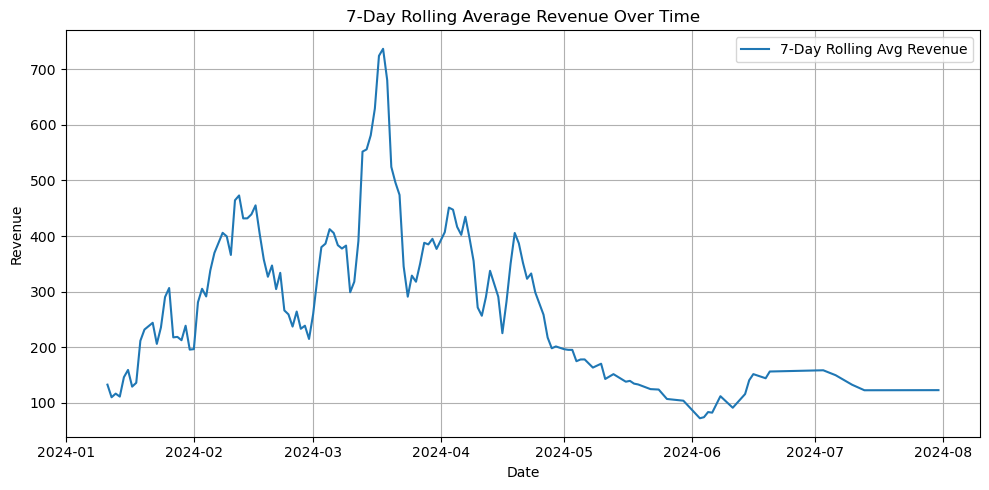

In [16]:
# Step 1 - Preprocessing Data 
# Convert Order_Date from a string (text) into a proper datetime format
orders['order_date'] = pd.to_datetime(orders['order_date'])


# Step 2 - Calculation of Total Revenue per Day
# Step 2.1) Groups the dataset by the date (Group By)
# Step 2.2) Sums the revenue for each day (Sum)
# Step 2.3) Then it converts the result from a Series to a DataFrame (Reset_Index)
# Step 2.4) Sorts the results in ascending order (Sort_Values)
Daily_Revenue = (orders.groupby('order_date')['revenue'].sum().reset_index().sort_values('order_date'))


# Step 3: Calculate 7-day Rolling Average of Revenue
# Step 3.1) It targets the daily revenue column 
# Step 3.2) It creates a 7-day moving window (Rolling Window)
# Step 3.3) Then it calculates the average of each 7-day period (Mean)
Daily_Revenue ['Rolling_7_Day_Avg'] = Daily_Revenue['revenue'].rolling(window=7).mean()


print (Daily_Revenue['Rolling_7_Day_Avg'])


plt.figure(figsize=(10, 5))
plt.plot(Daily_Revenue['order_date'], Daily_Revenue['Rolling_7_Day_Avg'], label='7-Day Rolling Avg Revenue')
plt.title('7-Day Rolling Average Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)     # It adds the grid to the plot for better clarity & readability 
plt.legend()       # It displays the legend (labels for lines)
plt.tight_layout() # It prevents labels or titles from being cut-off or any overlapping
plt.show()

Analysis Task 5
Trend and Retention Analysis

b) Estimate retention: % of customers who placed repeat orders within 30, 60, and 90 days.

Retention Rate for 30 Days is 71 %
Retention Rate for 60 Days is 92 %
Retention Rate for 90 Days is 93 %


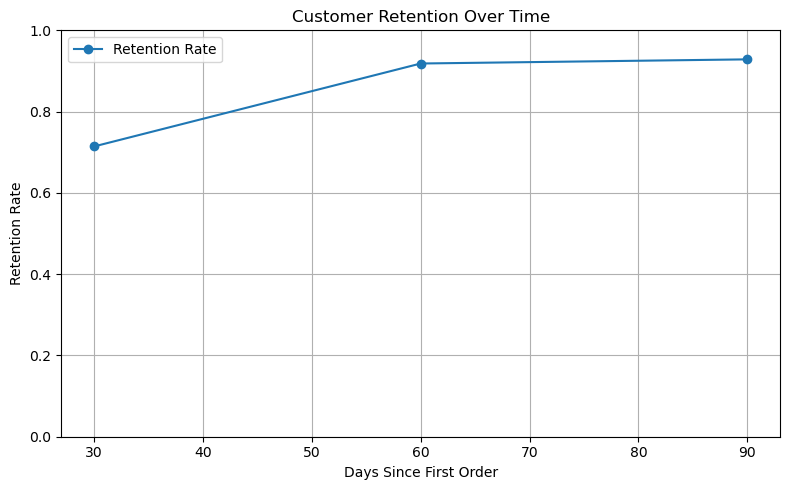

In [28]:
# Step 1 - Identification of the First Order Date of Each Customer
# Step 1.1) Groups the orders table by customer_id (Group by)
# Step 1.2) Then, select order dates to analyze (order_date)
# Step 1.3) Then, it creates a new column into the same table (Transform)
# Step 1.3) Afterward, find the earliest date for each customer (min)
orders['first_order_date'] = orders.groupby('customer_id')['order_date'].transform('min')


# Step 2 - Filter Reorders (Second, Third, etc.)
# Step 2.1) Only keep rows where order_date > first_order_date
Reordered_Customers = orders[orders['order_date'] > orders['first_order_date']]


# Step 3 - Retention Metrics
# Step 3.1) Count unique total customers
# Step 3.2) Calculate retention rate within 30 days
# Step 3.3) Calculate retention rate within 60 days
# Step 3.4) Calculate retention rate within 90 days

total_customers = orders['customer_id'].nunique()

Retention_30 = Reordered_Customers[(Reordered_Customers['order_date'] - Reordered_Customers['first_order_date']).dt.days <= 30]['customer_id'].nunique() / total_customers
Retention_60 = Reordered_Customers[(Reordered_Customers['order_date'] - Reordered_Customers['first_order_date']).dt.days <= 60]['customer_id'].nunique() / total_customers
Retention_90 = Reordered_Customers[(Reordered_Customers['order_date'] - Reordered_Customers['first_order_date']).dt.days <= 90]['customer_id'].nunique() / total_customers


print ("Retention Rate for 30 Days is", round (100* Retention_30),"%")
print ("Retention Rate for 60 Days is", round (100* Retention_60),"%")
print ("Retention Rate for 90 Days is", round (100* Retention_90),"%")


# Step 4 - Plotting the retention curve
days = [30, 60, 90]
rates = [Retention_30, Retention_60, Retention_90]

plt.figure(figsize=(8, 5))
plt.plot(days, rates, marker='o', label='Retention Rate')
plt.title('Customer Retention Over Time')
plt.xlabel('Days Since First Order')
plt.ylabel('Retention Rate')
plt.ylim(0, 1)
plt.grid(True)     # It adds the grid to the plot for better clarity & readability 
plt.legend()       # It displays the legend (labels for lines)
plt.tight_layout() # It prevents labels or titles from being cut-off or any overlapping
plt.show()

Further Analysis - Contribution of Sources to Conversions

In [26]:
# Filter only converted sessions
converted_sessions = web_sessions[web_sessions['converted'] == True]

# Group by source and count
conversion_by_source = converted_sessions.groupby('source').agg(
    converted_sessions_count=('session_id', 'count')
).reset_index()

# Calculate % share of total converted sessions
total_converted = conversion_by_source['converted_sessions_count'].sum()
conversion_by_source['conversion_share_%'] = round(
    100 * conversion_by_source['converted_sessions_count'] / total_converted, 2
)

# Sort descending
conversion_by_source = conversion_by_source.sort_values(by='conversion_share_%', ascending=False)
print(conversion_by_source)

        source  converted_sessions_count  conversion_share_%
1      organic                        28               25.45
3     referral                        25               22.73
2  paid_search                        24               21.82
0        email                        18               16.36
4       social                        15               13.64
